In [1]:
import sys
sys.path.append('../')
from src import optimizer as _optimizer
from src import visualization as _visualization
from src import metrics as _metrics
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np 
import seaborn as sns

sns.set(rc={'figure.figsize':(20,8)})
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
pd.set_option('display.max_rows', 120)

* https://towardsdatascience.com/quantile-regression-from-linear-models-to-trees-to-deep-learning-af3738b527c3
* https://towardsdatascience.com/lightgbm-for-quantile-regression-4288d0bb23fd
* https://towardsdatascience.com/deep-quantile-regression-in-tensorflow-1dbc792fe597
* https://github.com/sachinruk/KerasQuantileModel/blob/master/Keras%20Quantile%20Model.ipynb

## Reading / Displaying the Data 

In [2]:
df_dataset_v2 = pd.read_csv('../data/forecast_dataset_exp1.csv')

In [3]:
df_dataset_v2.describe()

,month,unit_markup,Y,hc_cluster_1,hc_cluster_2,hc_cluster_3,hc_cluster_4,hc_cluster_5,hc_cluster_6,hc_cluster_7,...,cat_code_1,cat_code_2,cat_code_3,cat_code_4,cat_code_5,cat_code_6,cat_code_7,cat_code_8,cat_code_9,cat_code_10
count,11190.000000,11190.000000,11190.000000,11190.000000,11190.000000,11190.000000,11190.000000,11190.00000,11190.000000,11190.000000,...,11190.000000,11190.000000,11190.000000,11190.000000,11190.000000,11190.000000,11190.000000,11190.000000,11190.000000,11190.000000
mean,6.231993,1.696202,13.589097,0.351921,0.533691,0.004558,0.020554,0.01412,0.009562,0.001519,...,0.002860,0.001787,0.003664,0.055764,0.009562,0.020554,0.001519,0.003307,0.010813,0.004558
std,3.594115,0.414477,34.622201,0.477591,0.498886,0.067359,0.141892,0.11799,0.097322,0.038949,...,0.053402,0.042241,0.060423,0.229476,0.097322,0.141892,0.038949,0.057410,0.103428,0.067359
min,1.000000,0.500000,1.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,1.400000,2.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,1.700000,4.000000,0.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,10.000000,2.000000,11.000000,1.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,12.000000,4.800000,643.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
df_dataset_v2.head()

,code,year_month,month,unit_markup,Y,hc_cluster_1,hc_cluster_2,hc_cluster_3,hc_cluster_4,hc_cluster_5,...,cat_code_1,cat_code_2,cat_code_3,cat_code_4,cat_code_5,cat_code_6,cat_code_7,cat_code_8,cat_code_9,cat_code_10
0,0671c2b9132a3f5215a4212ce0691694,2016-11,11,1.1,53,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0671c2b9132a3f5215a4212ce0691694,2016-11,11,1.2,92,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0671c2b9132a3f5215a4212ce0691694,2016-11,11,1.3,28,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0671c2b9132a3f5215a4212ce0691694,2016-11,11,1.4,61,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0671c2b9132a3f5215a4212ce0691694,2016-11,11,1.5,21,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
X_cols = [c for c in df_dataset_v2.columns if c not in ['year_month', 'Y'] and 'hc_cluster' not in c]

In [6]:
df_dataset_v2['code'] = df_dataset_v2['code'].astype('category').cat.codes

In [7]:
df_dataset_v2[X_cols].head()

,code,month,unit_markup,kmeans_cluster_0,kmeans_cluster_1,kmeans_cluster_2,kmeans_cluster_3,kmeans_cluster_4,kmeans_cluster_5,kmeans_cluster_6,...,cat_code_1,cat_code_2,cat_code_3,cat_code_4,cat_code_5,cat_code_6,cat_code_7,cat_code_8,cat_code_9,cat_code_10
0,0,11,1.1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,11,1.2,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,11,1.3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,11,1.4,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,11,1.5,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Splitting the Sets
* We will use the temporal series cross validation
* 3 months minimum intervals
* 3 training, 6 validation, 3 test
* 4 training, 5 validation, 3 test
* 5 training, 4 validation, 3 test
* 6 training, 3 validation, 3 test

In [8]:
df_train_val_test = pd.read_csv('../data/train_val_test.csv')

In [9]:
df_train_val_test

,set,train,val,reserved
0,0,"['2016-06', '2016-07', '2016-08']","['2016-09', '2016-10', '2016-11', '2016-12', '...",False
1,1,"['2016-06', '2016-07', '2016-08', '2016-09']","['2016-10', '2016-11', '2016-12', '2017-01', '...",False
2,2,"['2016-06', '2016-07', '2016-08', '2016-09', '...","['2016-11', '2016-12', '2017-01', '2017-02']",False
3,3,"['2016-06', '2016-07', '2016-08', '2016-09', '...","['2016-12', '2017-01', '2017-02']",False
4,4,"['2016-06', '2016-07', '2016-08', '2016-09', '...","['2017-01', '2017-02']",False
5,5,"['2016-06', '2016-07', '2016-08', '2016-09', '...",['2017-02'],False
6,6,"['2016-06', '2016-07', '2016-08', '2016-09', '...","['2017-03', '2017-04', '2017-05']",True


## Regressors Init

In [10]:
regressors = {}
RANDOM_STATE = 42
q =0.5

In [11]:
import lightgbm as lgb
gbm = lgb.LGBMRegressor(random_state=RANDOM_STATE)
regressors['gbm'] = gbm

In [12]:
import lightgbm as lgb
gbm_q = lgb.LGBMRegressor(alpha=q, objective = 'quantile',
    metric = 'quantile',random_state=RANDOM_STATE)
regressors['gbm_q'] = gbm_q

In [13]:
from sklearn.ensemble import GradientBoostingRegressor
gb_q = GradientBoostingRegressor(loss='quantile', alpha=q)
regressors['gb_q'] = gb_q

In [14]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

## Train Eval



In [15]:
def parse_str_list(str_list):
    result = str_list.replace("'","").replace('[','').replace(']','').replace(' ', '').split(',')
    return result

In [16]:
sets = list(df_train_val_test[~df_train_val_test.reserved].set.values)
sets

[0, 1, 2, 3, 4, 5]

In [17]:
results = []
for r_name, r in regressors.items():
    for s in sets:
        df_set = df_train_val_test[~df_train_val_test.reserved & (df_train_val_test.set == s)]

        x_scaler = StandardScaler()
        
        train_years = parse_str_list(df_set.train.values[0])
        val_years = parse_str_list(df_set.val.values[0])
        print(f'Training {r_name} on set {s}')
        

        df_train = df_dataset_v2[df_dataset_v2.year_month.isin(train_years)]
        df_val = df_dataset_v2[df_dataset_v2.year_month.isin(val_years)]
#         print(df_train.year_month.unique(), train_years)
#         print(df_val.year_month.unique(), val_years)
    
        y_train = df_train['Y'].values    
        
        r_inst = r.fit(X=x_scaler.fit_transform(df_train[X_cols]), y=y_train)
        
        print(f'Validating {r_name}  on set {s}')
        y_val = df_val['Y']
        y_pred_val = r_inst.predict(x_scaler.transform(df_val[X_cols]))
        
        y_pred_val = y_pred_val
        m = _metrics.applyRegressionMetrics(y=y_val, y_pred=y_pred_val)
        m['reg_inst'] = r_inst
        m['r_name'] = r_name
        m['set'] = s
        results.append(m)
#         print(len(y_train), len(y_val))

    print()
df_results = pd.DataFrame(results)    

Training gbm on set 0
Validating gbm  on set 0
Training gbm on set 1
Validating gbm  on set 1
Training gbm on set 2
Validating gbm  on set 2
Training gbm on set 3
Validating gbm  on set 3
Training gbm on set 4
Validating gbm  on set 4
Training gbm on set 5
Validating gbm  on set 5

Training gbm_q on set 0
Validating gbm_q  on set 0
Training gbm_q on set 1
Validating gbm_q  on set 1
Training gbm_q on set 2
Validating gbm_q  on set 2
Training gbm_q on set 3
Validating gbm_q  on set 3
Training gbm_q on set 4
Validating gbm_q  on set 4
Training gbm_q on set 5
Validating gbm_q  on set 5

Training gb_q on set 0
Validating gb_q  on set 0
Training gb_q on set 1
Validating gb_q  on set 1
Training gb_q on set 2
Validating gb_q  on set 2
Training gb_q on set 3
Validating gb_q  on set 3
Training gb_q on set 4
Validating gb_q  on set 4
Training gb_q on set 5
Validating gb_q  on set 5



In [18]:
metric_list = []

In [19]:
df_results.groupby('r_name').agg({'RMSE':[pd.Series.mean, pd.Series.std],'MAPE':[pd.Series.mean, pd.Series.std],'MSE':[pd.Series.mean, pd.Series.std],'MAE':[pd.Series.mean, pd.Series.std],'R2':[pd.Series.mean, pd.Series.std],})

RMSE                MAPE                    MSE              \
             mean       std      mean       std         mean         std   
r_name                                                                     
gb_q    32.175808  3.787530  1.121930  0.135108  1047.237102  222.926969   
gbm     24.867130  3.373486  2.479145  0.582855   627.857853  155.556042   
gbm_q   28.238201  3.764013  1.342947  0.188893   809.202485  191.397512   

              MAE                  R2            
             mean       std      mean       std  
r_name                                           
gb_q    10.596427  1.483678  0.056549  0.052519  
gbm     11.148771  0.766609  0.437097  0.056919  
gbm_q   10.126882  1.447240  0.274664  0.064744

Training gbm on set 6
Validating gbm on set 6 and 2017-03
7626 1073
RMSE : 23.0529
MAPE': 1.7836
MDAPE': 0.6869
MSE: 531.4356
MAE: 9.3493
R2: 0.5444


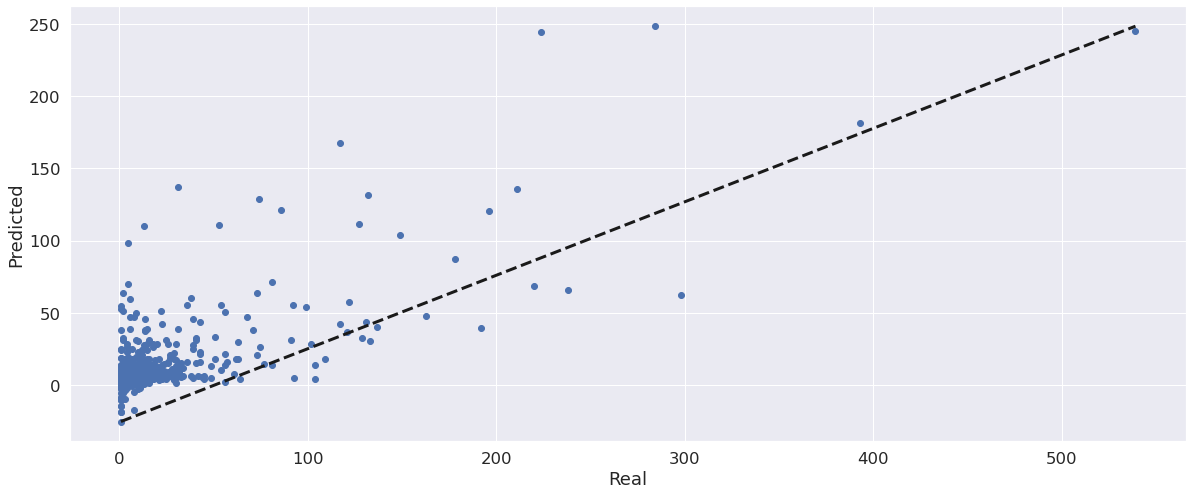

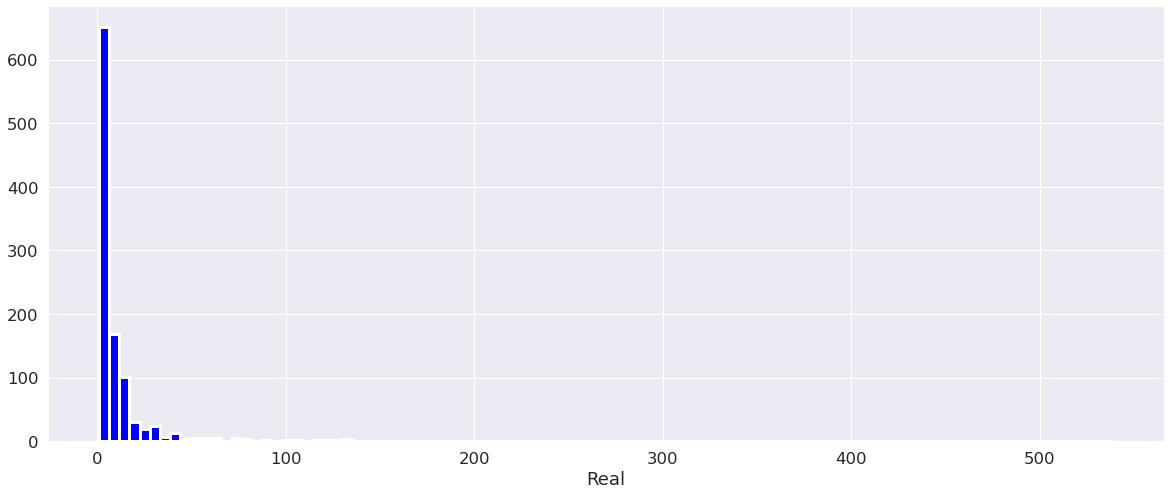

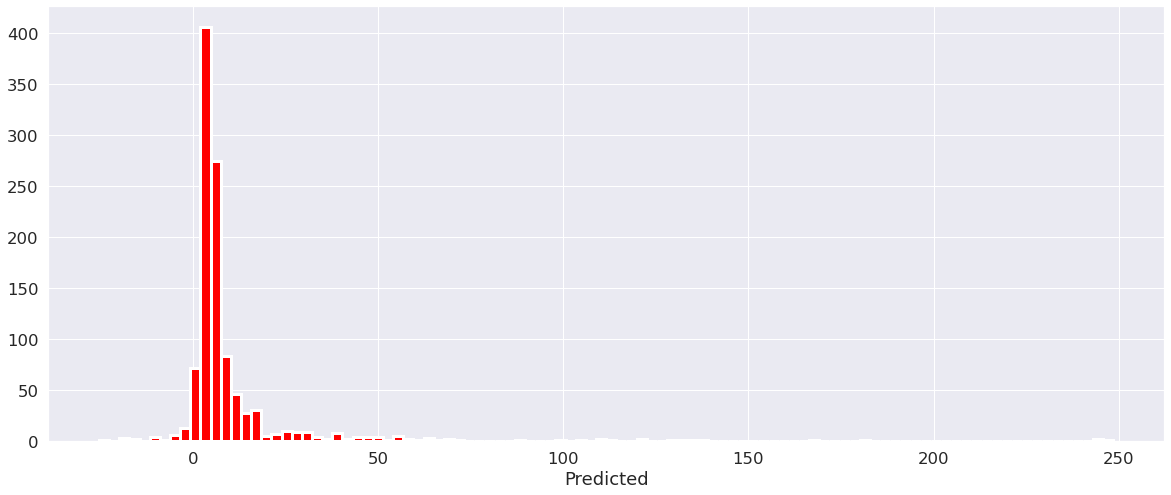


Validating gbm on set 6 and 2017-04
7626 1068
RMSE : 23.6565
MAPE': 1.9889
MDAPE': 0.6955
MSE: 559.6291
MAE: 9.2556
R2: 0.4147


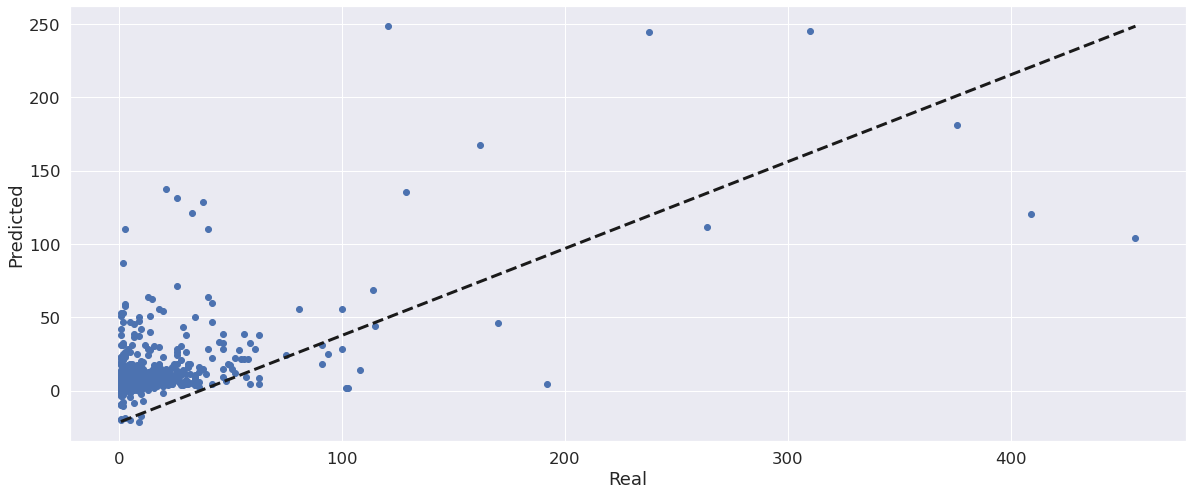

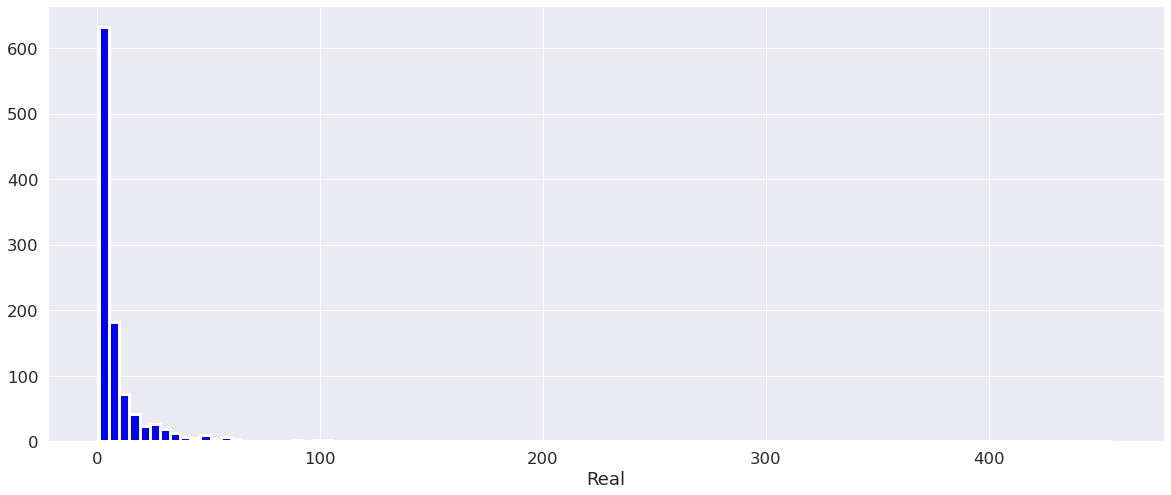

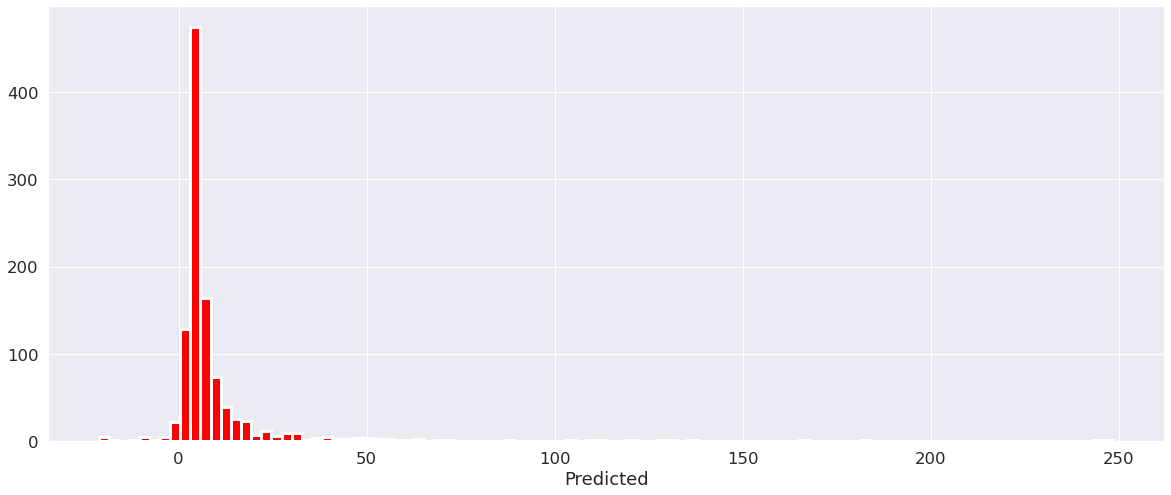


Validating gbm on set 6 and 2017-05
7626 1171
RMSE : 32.7552
MAPE': 1.7322
MDAPE': 0.6676
MSE: 1072.9060
MAE: 11.2318
R2: 0.3465


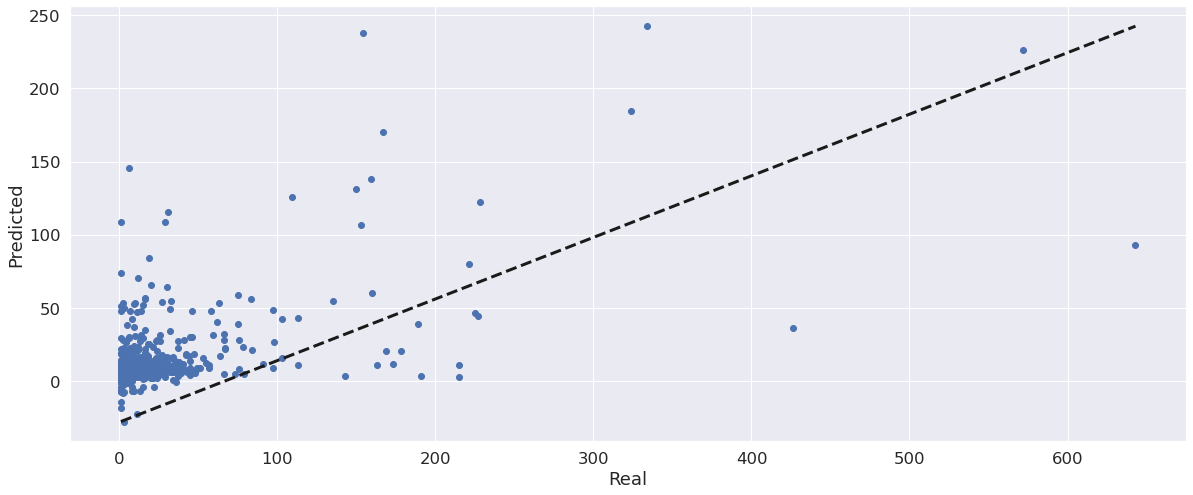

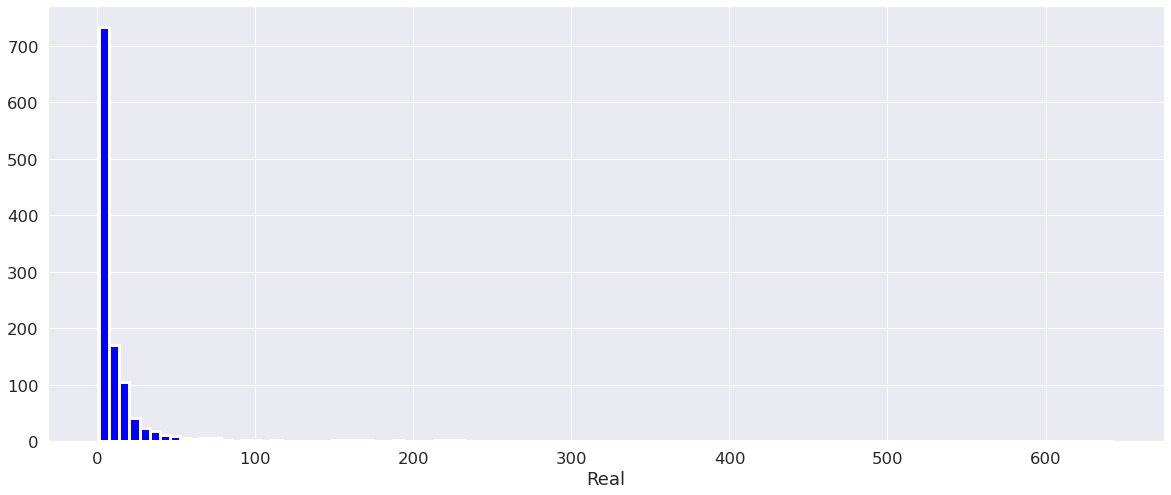

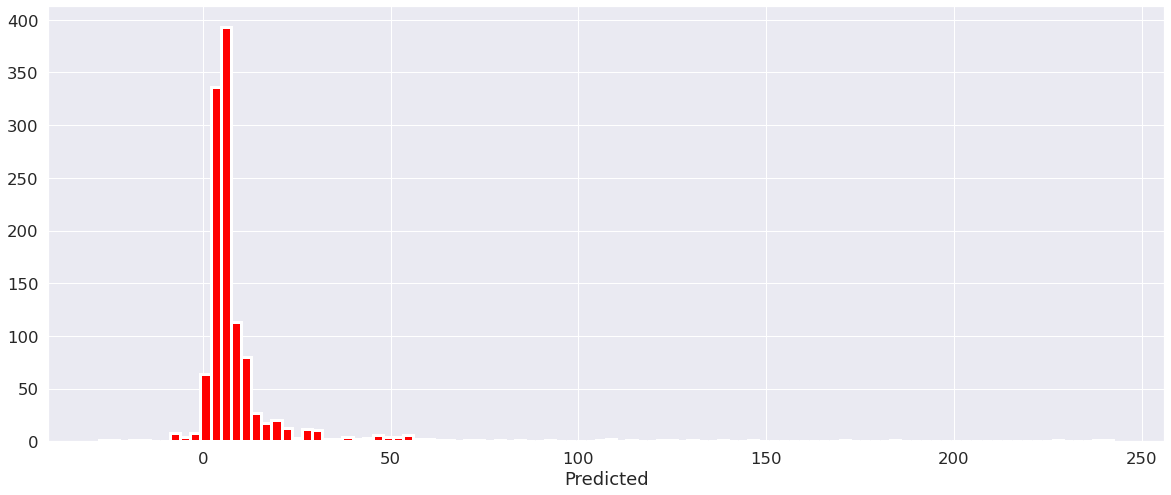


Training gbm_q on set 6
Validating gbm_q on set 6 and 2017-03
7626 1073
RMSE : 27.7972
MAPE': 1.1403
MDAPE': 0.5959
MSE: 772.6854
MAE: 9.5151
R2: 0.3376


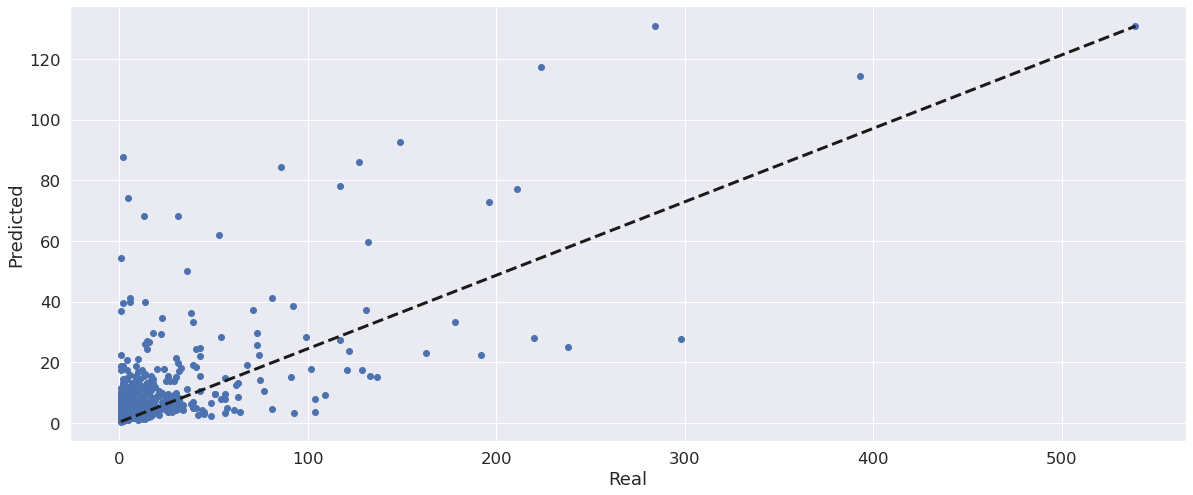

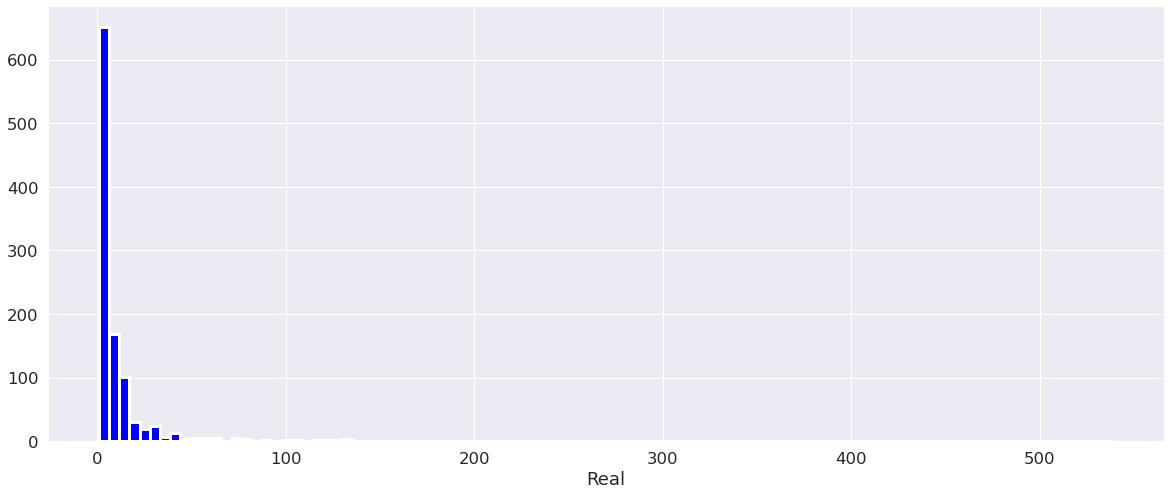

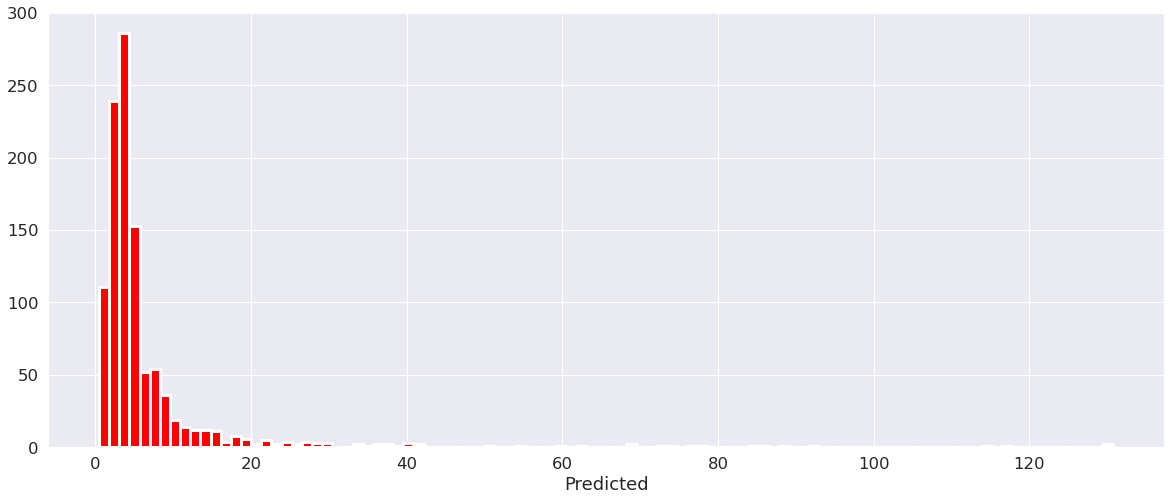


Validating gbm_q on set 6 and 2017-04
7626 1068
RMSE : 24.9447
MAPE': 1.3121
MDAPE': 0.6227
MSE: 622.2362
MAE: 8.5905
R2: 0.3492


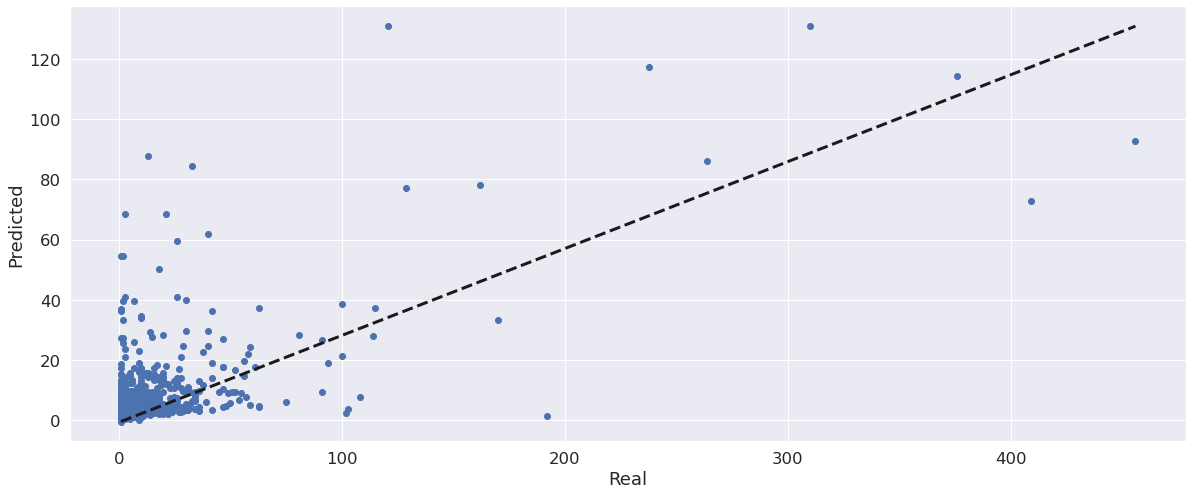

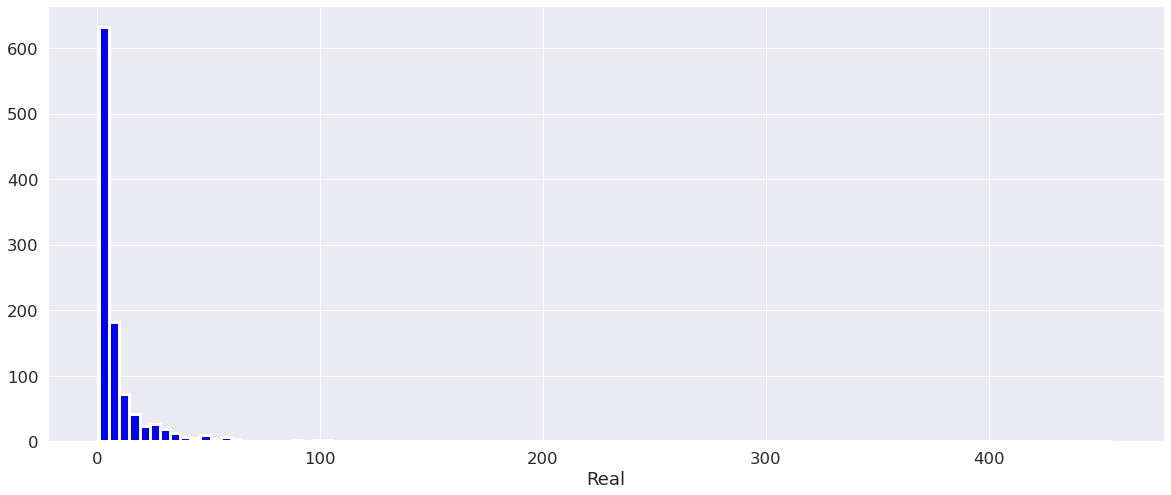

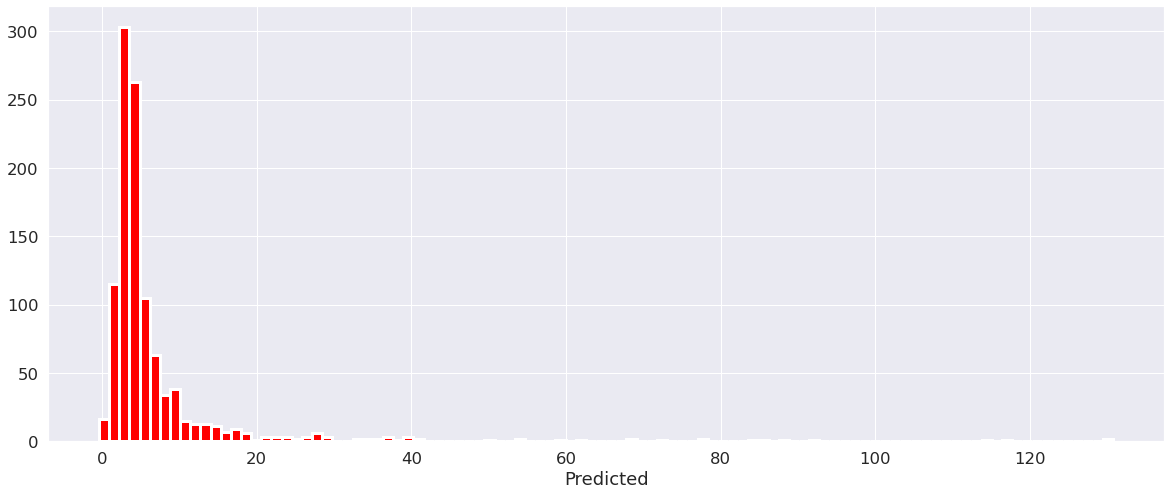


Validating gbm_q on set 6 and 2017-05
7626 1171
RMSE : 35.2618
MAPE': 1.0534
MDAPE': 0.6218
MSE: 1243.3972
MAE: 11.3688
R2: 0.2427


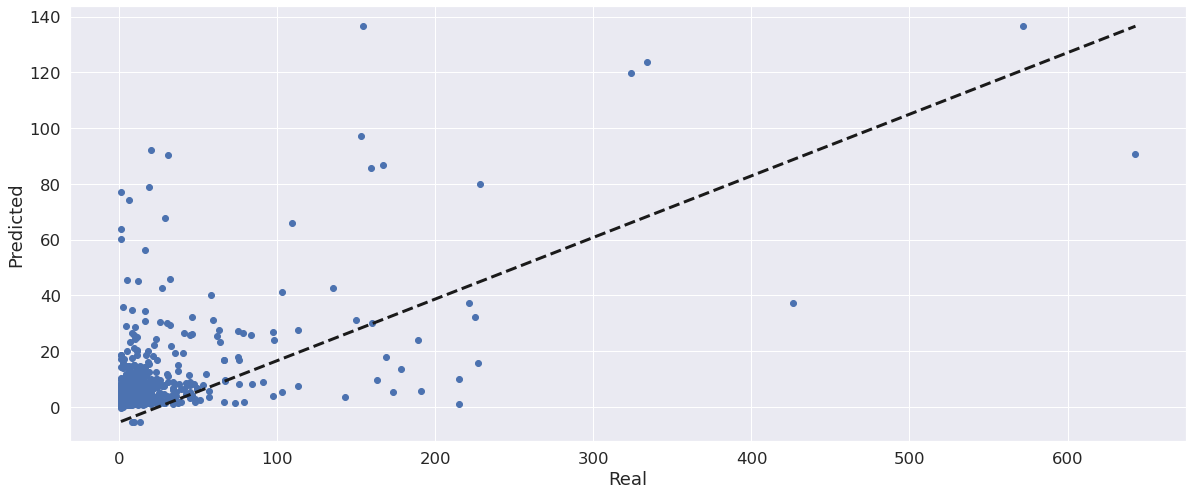

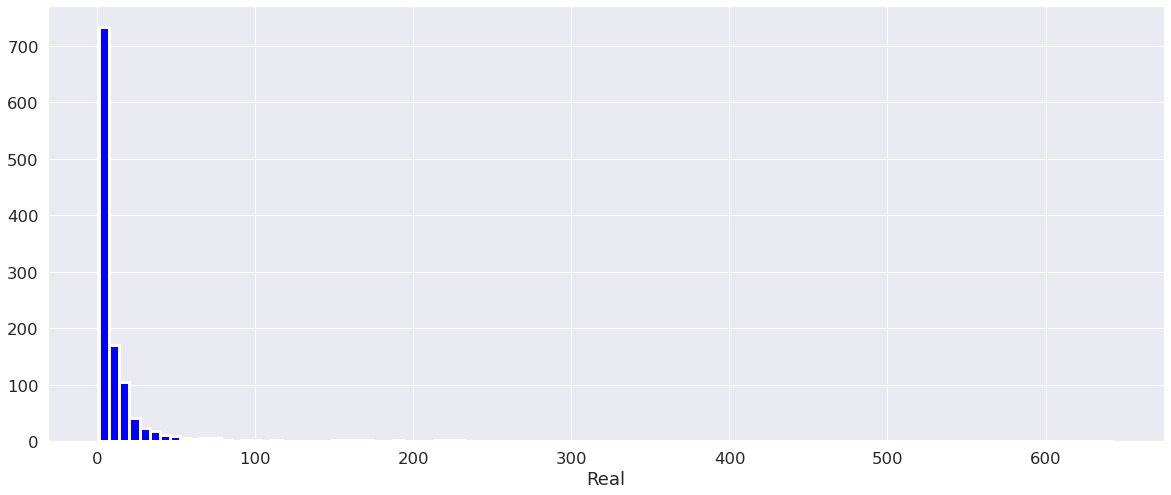

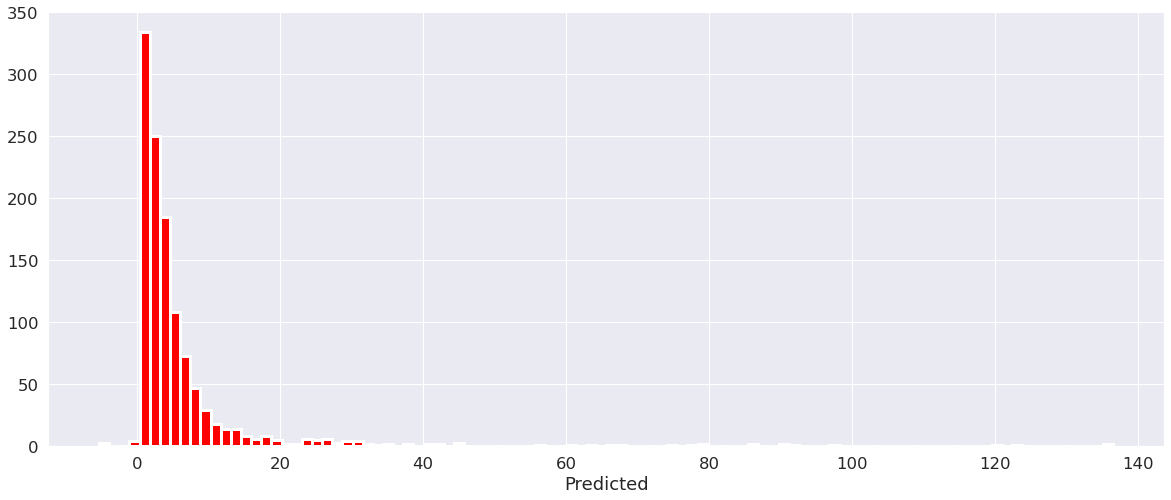


Training gb_q on set 6
Validating gb_q on set 6 and 2017-03
7626 1073
RMSE : 32.5803
MAPE': 1.1382
MDAPE': 0.6645
MSE: 1061.4759
MAE: 10.4985
R2: 0.0900


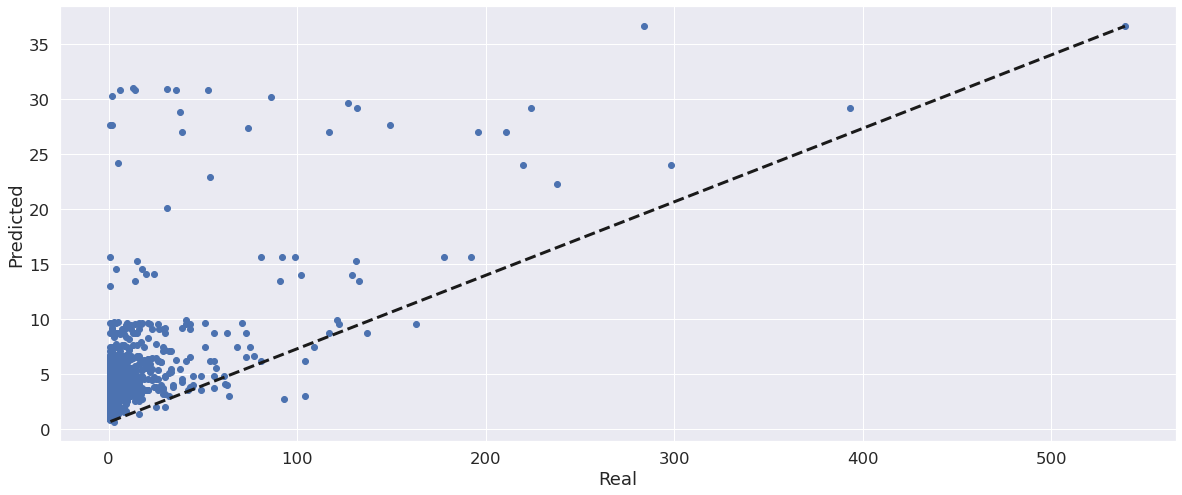

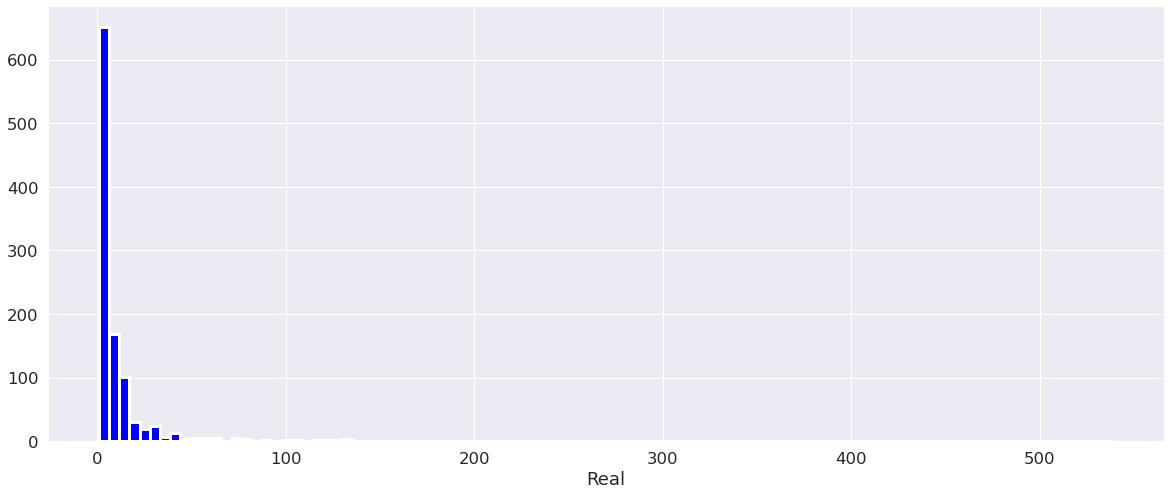

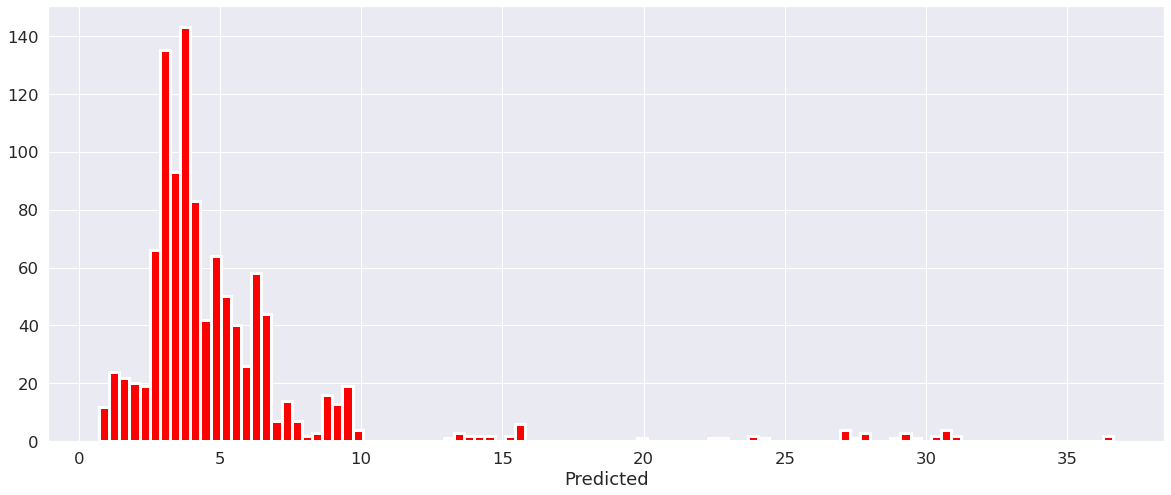


Validating gb_q on set 6 and 2017-04
7626 1068
RMSE : 29.4765
MAPE': 1.1078
MDAPE': 0.6739
MSE: 868.8627
MAE: 9.0930
R2: 0.0912


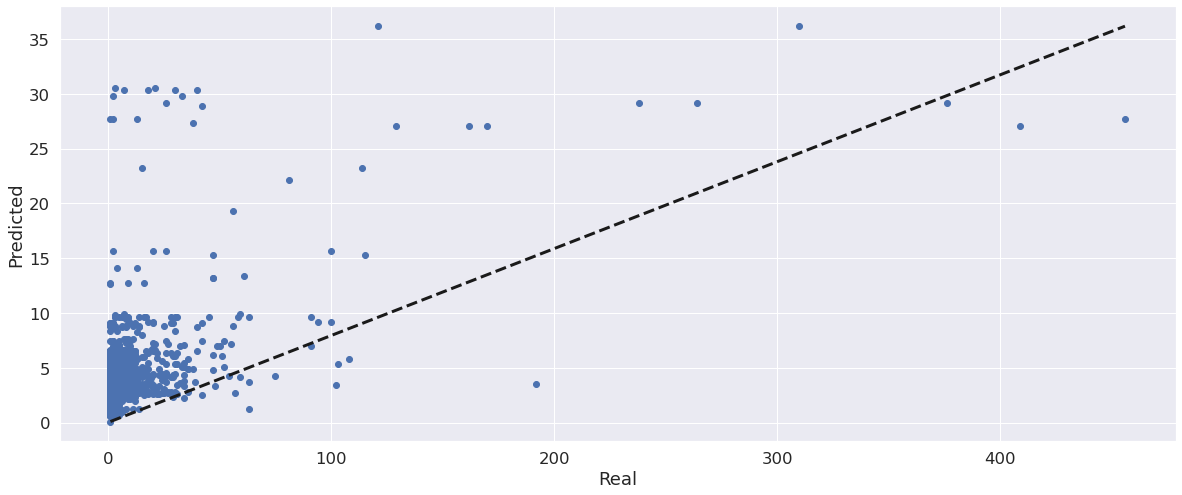

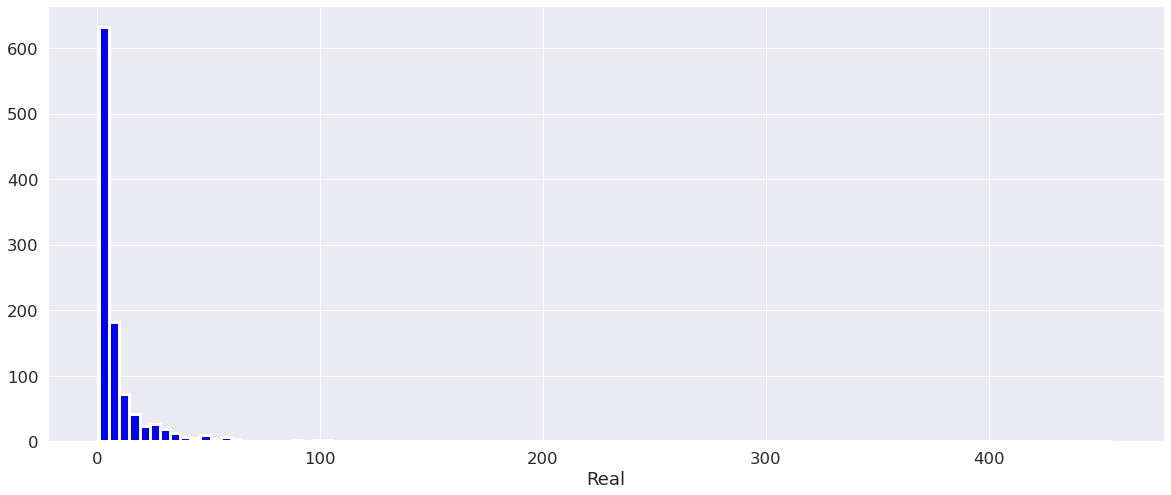

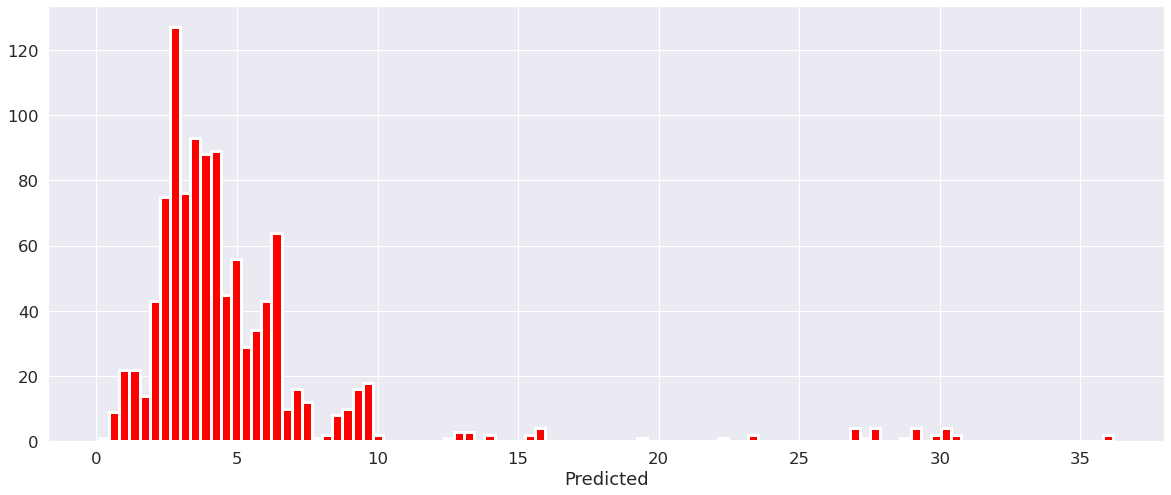


Validating gb_q on set 6 and 2017-05
7626 1171
RMSE : 39.7179
MAPE': 0.9455
MDAPE': 0.6364
MSE: 1577.5120
MAE: 11.8852
R2: 0.0391


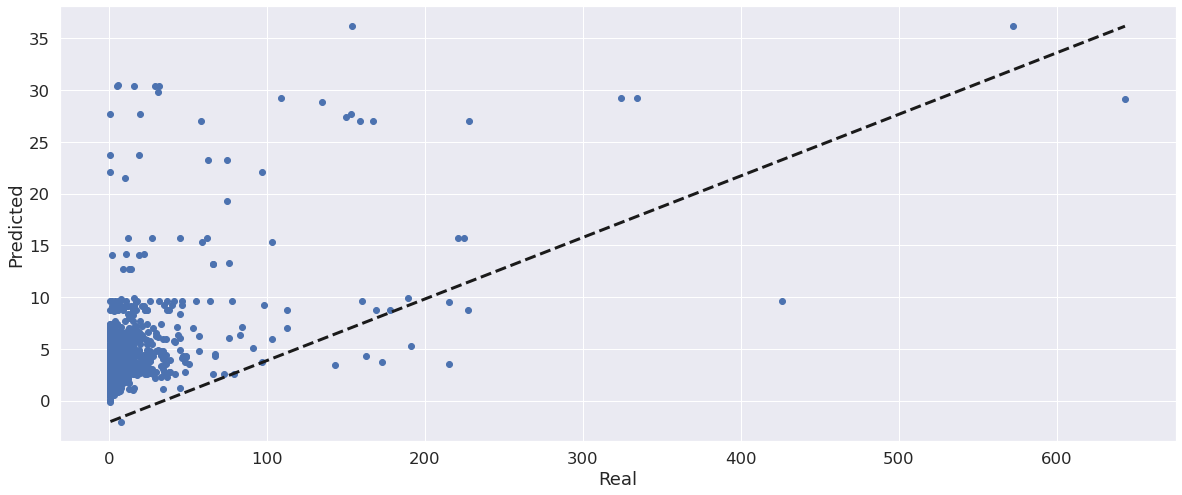

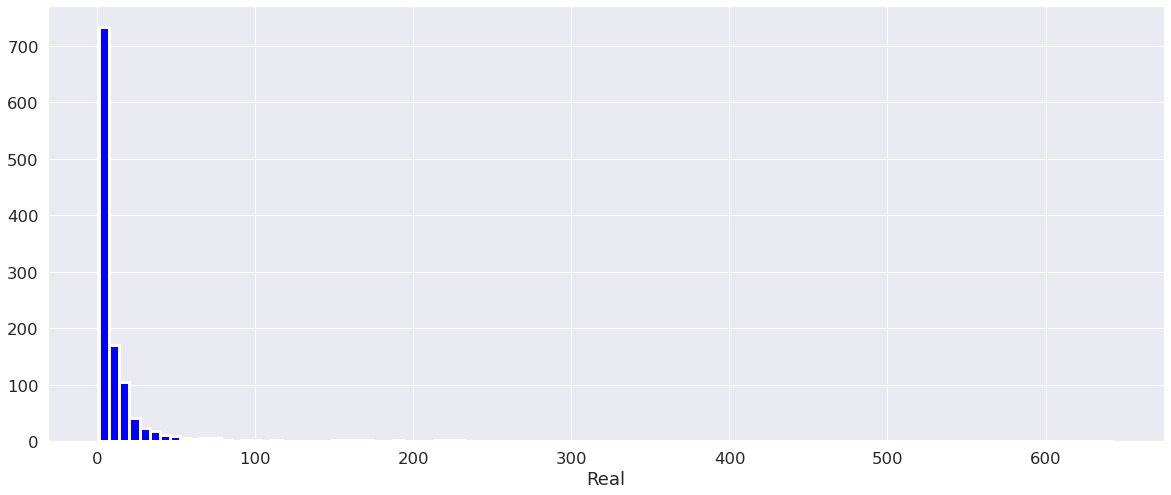

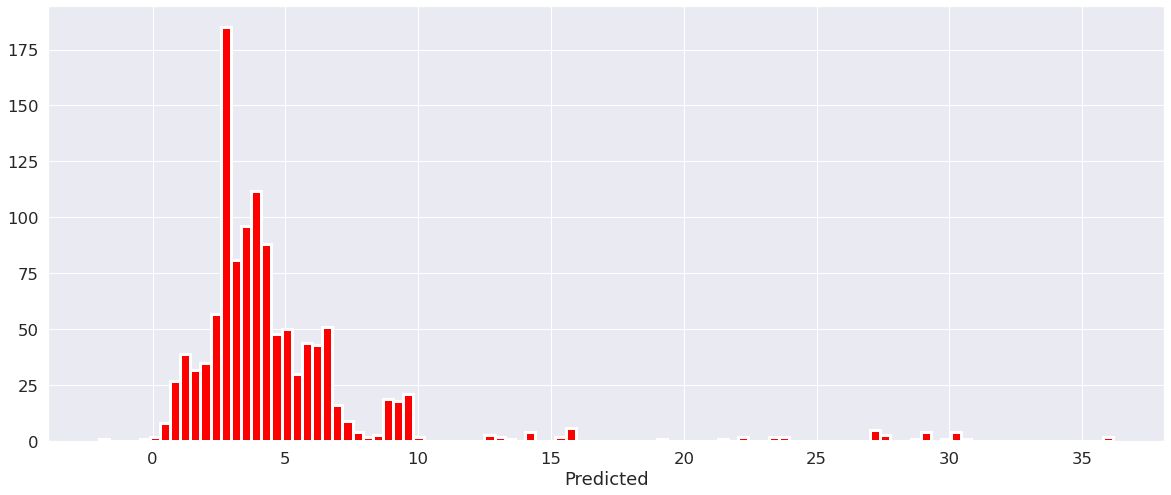

In [20]:
results = []
for r_name, r in regressors.items():
    s=6
    x_scaler = StandardScaler()

    df_set = df_train_val_test[(df_train_val_test.set == s)]

    x_scaler = StandardScaler()

    train_years = parse_str_list(df_set.train.values[0])
    val_years = parse_str_list(df_set.val.values[0])
    print(f'Training {r_name} on set {s}')

    df_train = df_dataset_v2[df_dataset_v2.year_month.isin(train_years)]    

    y_train = df_train['Y'].values    

    r_inst = r.fit(X=x_scaler.fit_transform(df_train[X_cols]), y=y_train.flatten())

    for val_year in val_years:
        df_val = df_dataset_v2[df_dataset_v2.year_month == val_year]
        print(f'Validating {r_name} on set {s} and {val_year}')
        y_val = df_val['Y']
        y_pred_val = r_inst.predict(x_scaler.transform(df_val[X_cols]))

        y_pred_val = y_pred_val
        m = _metrics.applyRegressionMetrics(y=y_val, y_pred=y_pred_val)
        m['reg_inst'] = r_inst
        m['r_name'] = r_name
        m['set'] = s
        m['year_month'] = val_year
        results.append(m)
        print(len(y_train), len(y_val))
        _metrics.evaluateRegression(y=y_val, y_pred=y_pred_val)
        print()
df_results = pd.DataFrame(results)    

In [21]:
df_results

,y,y_pred,RMSE,MAPE,MDAPE,MSE,MAE,R2,reg_inst,r_name,set,year_month
0,51 238 52 298 53 220 54 ...,"[65.57665570357618, 62.61925515703858, 68.7422...",23.052887,1.783584,0.686890,531.435591,9.349289,0.544389,LGBMRegressor(random_state=42),gbm,6,2017-03
1,65 15 66 114 67 81 68 ...,"[62.61925515703858, 68.74225959554096, 55.6415...",23.656482,1.988855,0.695478,559.629126,9.255636,0.414673,LGBMRegressor(random_state=42),gbm,6,2017-04
2,77 10 78 63 79 75 80 9...,"[53.43684745030078, 53.03528821778779, 59.0230...",32.755244,1.732250,0.667585,1072.905999,11.231810,0.346501,LGBMRegressor(random_state=42),gbm,6,2017-05
3,51 238 52 298 53 220 54 ...,"[24.973004356129593, 27.819448390205565, 27.87...",27.797219,1.140251,0.595862,772.685406,9.515104,0.337560,"LGBMRegressor(alpha=0.5, metric='quantile', ob...",gbm_q,6,2017-03
4,65 15 66 114 67 81 68 ...,"[27.819448390205565, 27.87983392757797, 28.231...",24.944662,1.312059,0.622679,622.236174,8.590477,0.349191,"LGBMRegressor(alpha=0.5, metric='quantile', ob...",gbm_q,6,2017-04
5,77 10 78 63 79 75 80 9...,"[24.47897276045346, 27.433986152840397, 27.093...",35.261838,1.053372,0.621831,1243.397233,11.368838,0.242656,"LGBMRegressor(alpha=0.5, metric='quantile', ob...",gbm_q,6,2017-05
6,51 238 52 298 53 220 54 ...,"[22.303759017627993, 24.003759017627996, 24.00...",32.580299,1.138178,0.664483,1061.475873,10.498542,0.089974,([DecisionTreeRegressor(criterion='friedman_ms...,gb_q,6,2017-03
7,65 15 66 114 67 81 68 ...,"[23.228016357793493, 23.228016357793493, 22.11...",29.476477,1.107802,0.673893,868.862718,9.092958,0.091240,([DecisionTreeRegressor(criterion='friedman_ms...,gb_q,6,2017-04
8,77 10 78 63 79 75 80 9...,"[21.52801635779349, 23.228016357793493, 23.228...",39.717906,0.945457,0.636360,1577.512039,11.885225,0.039149,([DecisionTreeRegressor(criterion='friedman_ms...,gb_q,6,2017-05
